In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
from xgcm import Grid
import fsspec
fs = fsspec.filesystem(
    "s3",
    profile="emulator",  ## This is the profile name you configured above.
    client_kwargs={"endpoint_url": "https://nyu1.osn.mghpcc.org"},
)

In [2]:
def open_ocean_dataset(ocean_dataset_nc_files, ocean_dataset_monthly_layer_thickness_files, ocean_layer_thickness, nc_grid_path):
    with fs.open(ocean_dataset_nc_files) as f:
        ds = xr.open_dataset(f).load()
    with fs.open(ocean_dataset_monthly_layer_thickness_files) as f:
        ds_monthly = xr.open_dataset(f).load()
    upsampled = ds_monthly.interp(
        Time=ds.Time.values, method="nearest", kwargs={"fill_value": "extrapolate"}
    )
    ds["layer_thickness"] = upsampled[ocean_layer_thickness]

    depth = np.zeros((len(upsampled.Time), len(upsampled.nVertLevels)+1, len(upsampled.lat), len(upsampled.lon)))
    depth[:, 0, :, :] = upsampled["timeMonthly_avg_ssh"].values
    for i in range(1, len(upsampled.nVertLevels)+1):
        depth[:, i, :, :] = depth[:, i-1, :, :] - upsampled["timeMonthly_avg_layerThickness"].isel(nVertLevels=i-1).values
    depth = abs(depth)
    ds["depth"] = xr.DataArray(depth, dims=["Time", "nVertLevelsOuter", "lat", "lon"])

    depth_center = np.zeros((len(upsampled.Time), len(upsampled.nVertLevels), len(upsampled.lat), len(upsampled.lon)))
    depth_center = (depth[:, 1:, :, :] + depth[:, :-1, :, :]) / 2
    ds["depth_center"] = xr.DataArray(depth_center, dims=["Time", "nVertLevels", "lat", "lon"])

    with fs.open(nc_grid_path) as f:
        mesh = xr.open_dataset(f).load()
    ds["refBottomDepth"] = mesh.refBottomDepth
    wetmask = np.isnan(mesh.temperature.isel(Time=0))
    ds["wetmask"] = wetmask
    ds.wetmask.attrs["long_name"] = "wet mask"
    ds.wetmask.attrs["units"] = ""
    return ds

In [3]:

nc_grid_path = "s3://emulators/ai2_colab/2024-11-18-e3sm-vertical-coarsening-debug/mpaso.IcoswISC30E3r5.regrid.nc" 
vertical_dim = "nVertLevels"
ocean_layer_thickness = "timeMonthly_avg_layerThickness"
ocean_dataset_nc_files = "s3://emulators/ai2_colab/2024-11-18-e3sm-vertical-coarsening-debug/v3.LR.piControl_bonus.mpaso.hist.am.timeSeriesStatsCustom.0480-01-01.nc"
ocean_dataset_monthly_layer_thickness_files = "s3://emulators/ai2_colab/2024-11-18-e3sm-vertical-coarsening-debug/v3.LR.piControl_bonus.mpaso.hist.am.timeSeriesStatsMonthly.0480-01-01.nc"

In [4]:
target_vertical_center = np.array([2.50e+00, 1.00e+01, 2.25e+01, 4.00e+01, 6.50e+01, 1.05e+02, 1.65e+02,
 2.50e+02, 3.75e+02, 5.50e+02, 7.75e+02, 1.05e+03, 1.40e+03, 1.85e+03,
 2.40e+03, 3.10e+03, 4.00e+03, 5.00e+03, 6.00e+03])

target_vertical_levels = np.array([0.0e+00, 5.0e+00, 1.5e+01, 3.0e+01, 5.0e+01, 8.0e+01, 1.3e+02,
 2.0e+02, 3.0e+02, 4.5e+02, 6.5e+02, 9.0e+02, 1.2e+03, 1.6e+03,
 2.1e+03, 2.7e+03, 3.5e+03, 4.5e+03, 5.5e+03, 6.5e+03])

In [5]:
ds = open_ocean_dataset(ocean_dataset_nc_files, ocean_dataset_monthly_layer_thickness_files, ocean_layer_thickness, nc_grid_path)
ds = ds.rename_dims({"nVertLevels": "lev", "nVertLevelsOuter": "lev_outer"})
ds = ds.assign_coords({"lev": np.arange(64), "lev_outer": np.arange(65)})

In [6]:
grid = Grid(
    ds,
    coords={"Z": {"center": "lev", "outer": "lev_outer"}},
    boundary="fill",
    periodic=False,
    autoparse_metadata=False,
)
dz = ds["layer_thickness"]
variable_names = ["timeCustom_avg_activeTracers_salinity", "timeCustom_avg_activeTracers_temperature"]
ds_extensive = ds[variable_names] * dz
ds_extensive = ds_extensive.assign_coords({"lev_outer": np.arange(65)})
ds_extensive_regridded = xr.Dataset()
for var in variable_names:
    ds_extensive_regridded[var] = grid.transform(
        ds_extensive[var],
        "Z",
        target_vertical_levels,
        target_data=ds.depth,
        method="conservative",
    )
ds_extensive_regridded = ds_extensive_regridded.rename({"depth": "lev"})
dz_regridded = xr.DataArray(
    np.diff(target_vertical_levels),
    dims=["lev"],
    coords={"lev": ds_extensive_regridded.lev},
)
ds_regridded = ds_extensive_regridded / dz_regridded
ds_regridded = ds_regridded.assign_coords(dz=dz_regridded)
for co_name, co in ds.coords.items():
    if "lev" not in co.dims:
        ds_regridded = ds_regridded.assign_coords({co_name: co})
ds_regridded = ds_regridded.drop_vars("lev_outer")
ds_regridded = ds_regridded.drop_vars("lev").rename_dims(
    {"lev": vertical_dim}
)
ds_regridded = ds_regridded.drop_vars("dz")

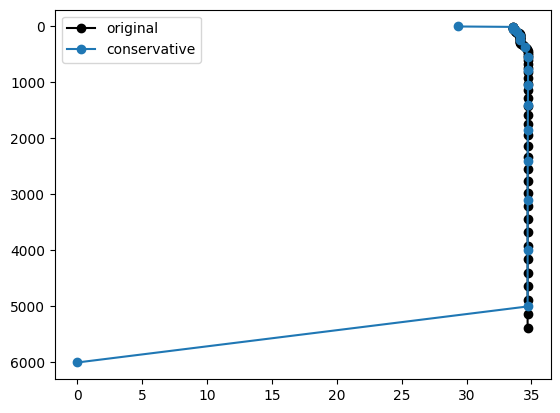

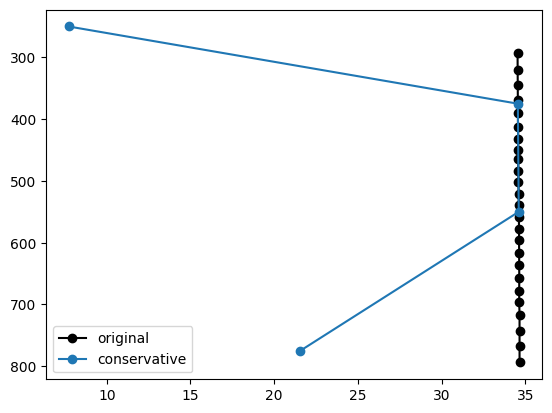

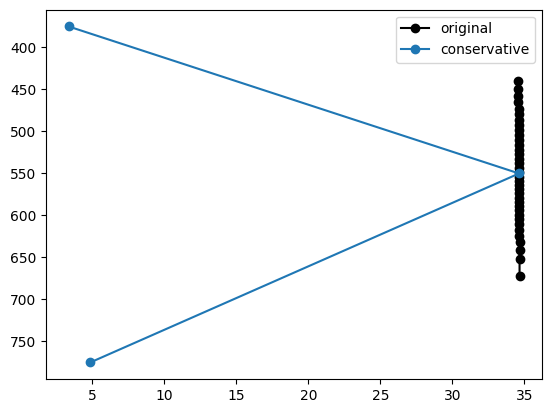

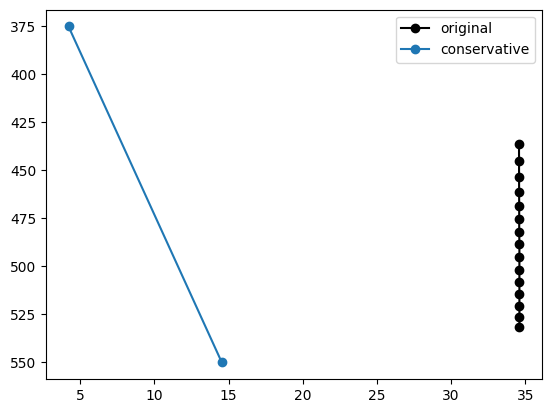

In [8]:
nan_count = ds_regridded.timeCustom_avg_activeTracers_salinity.isel(Time=0).isnull().sum(dim="nVertLevels")
for i in [0, 15, 16, 17]:
    time, lat, lon = 0, np.where(nan_count == i)[0][0], np.where(nan_count == i)[1][0]
    plt.figure()
    plt.plot(ds.timeCustom_avg_activeTracers_salinity.isel(Time=time, lat=lat, lon=lon), ds.depth_center.isel(Time=time, lat=lat, lon=lon), "-o", color="k", label="original")
    plt.gca().invert_yaxis()

    plt.plot(ds_regridded.timeCustom_avg_activeTracers_salinity.isel(Time=time, lat=lat, lon=lon), target_vertical_center, "-o", label="conservative")
    plt.legend()